In [1]:
import pandas as pd
data_dir = "https://raw.githubusercontent.com/OscarEngelbrektson/SyntheticControlMethods/master/examples/datasets/"
df = pd.read_csv(data_dir + "smoking_data" + ".csv").drop(columns=["lnincome","beer", "age15to24"])
df.head()

,state,year,cigsale,retprice
0,Alabama,1970.0,89.8,39.6
1,Alabama,1971.0,95.4,42.7
2,Alabama,1972.0,101.1,42.3
3,Alabama,1973.0,102.9,42.1
4,Alabama,1974.0,108.2,43.1


In [2]:
treatment_year = 1988
treated_state = 'California'
df.head()

,state,year,cigsale,retprice
0,Alabama,1970.0,89.8,39.6
1,Alabama,1971.0,95.4,42.7
2,Alabama,1972.0,101.1,42.3
3,Alabama,1973.0,102.9,42.1
4,Alabama,1974.0,108.2,43.1


In [3]:
df=df.pivot(index= 'year', columns = 'state', values = "cigsale").reset_index()

In [4]:
df.head()

state,year,Alabama,Arkansas,California,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,...,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming
0,1970.0,89.8,100.3,123.0,124.8,120.0,155.0,109.9,102.4,124.8,...,103.6,92.7,99.8,106.4,65.5,122.6,124.3,114.5,106.4,132.2
1,1971.0,95.4,104.1,121.0,125.5,117.6,161.1,115.7,108.5,125.6,...,115.0,96.7,106.3,108.9,67.7,124.4,128.4,111.5,105.4,131.7
2,1972.0,101.1,103.9,123.5,134.3,110.8,156.3,117.0,126.1,126.6,...,118.7,103.0,111.5,108.6,71.3,138.0,137.0,117.5,108.8,140.0
3,1973.0,102.9,108.0,124.4,137.9,109.3,154.7,119.8,121.8,124.4,...,125.5,103.5,109.7,110.4,72.7,146.8,143.1,116.6,109.5,141.2
4,1974.0,108.2,109.7,126.7,132.8,112.4,151.3,123.7,125.6,131.9,...,129.7,108.4,114.8,114.7,75.6,151.8,149.6,119.9,111.8,145.8


In [5]:
states = [x for x in df.columns if x!='year']
df['Other States'] = df[[x for x in states if x!=treated_state and x!= 'year']].mean(axis=1)

In [6]:
import seaborn as sns
from matplotlib import pyplot as plt
def plot_sales(df,treated_state,col_2,treatment_year):
    plt.figure(figsize=(10,4))
    plt.plot(df['year'],df[treated_state], label=treated_state)
    plt.plot(df['year'],df[col_2], label = col_2)
    plt.axvline(x=treatment_year, ls=":", color='C2', label='treatment year', zorder=1)
    plt.legend()
    plt.title("Average cig sale per year")
    plt.show()

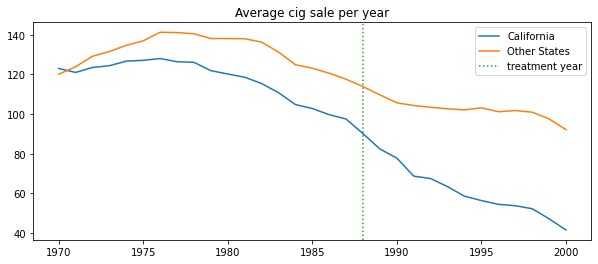

In [7]:
plot_sales(df,treated_state,'Other States',treatment_year)

In [8]:
def predict_synthetic_data(df, model, state, year):
    other_states = [x for x in states if x not in [state]]
    y = df[df['year']<=year][state]
    X = df[df['year']<=year][other_states]
    state_col = 'Synthetic '+ state
    df[state_col] = model.fit(X, y).predict(df[other_states])
    return model

In [9]:
from toolz import partial
from scipy.optimize import fmin_slsqp

class SyntheticControl():
    
    # Loss function
    def loss(self, W, X, y) -> float:
        return np.sqrt(np.mean((y - X.dot(W))**2))

    # Fit model
    def fit(self, X, y):
        w_start = [1/X.shape[1]]*X.shape[1]
        self.coef_ = fmin_slsqp(partial(self.loss, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
        self.mse = self.loss(W=self.coef_, X=X, y=y)
        return self
    
    # Predict 
    def predict(self, X):
        return X.dot(self.coef_)

In [10]:
from sklearn.linear_model import LinearRegression
coef = predict_synthetic_data(df, LinearRegression(), treated_state, treatment_year).coef_

In [11]:
df_states = pd.DataFrame({'state': [x for x in states if x not in [treated_state, 'year']]})

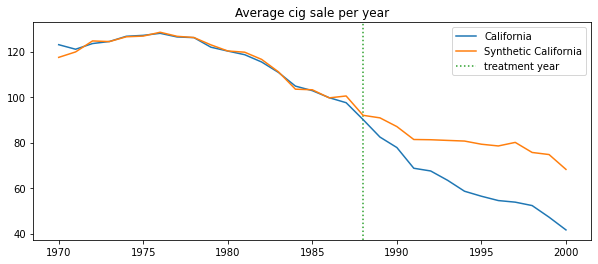

In [12]:
import numpy as np
df_states['coef_synth'] = predict_synthetic_data(df, SyntheticControl(), treated_state, treatment_year).coef_
plot_sales(df, treated_state, f'Synthetic {treated_state}', treatment_year)

In [13]:
def plot_difference(df, state, year, vline=True, hline=True, **kwargs):
    sns.lineplot(x=df['year'], y=df[state] - df[f'Synthetic {state}'], **kwargs)
    if vline: 
        plt.axvline(x=year, ls=":", color='C2', label='Intervention year', lw=3, zorder=100)
        plt.legend()
    if hline: sns.lineplot(x=df['year'], y=0, lw=3, color='k', zorder=1)
    plt.title("Estimated effect of Proposition 99 on cigsale");

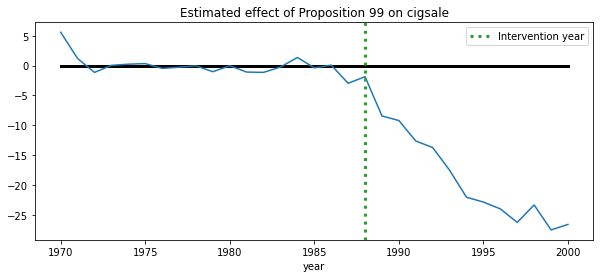

In [14]:
# fig, ax = plt.subplots()
# for state in states:
#     predict_synthetic_data(df, SyntheticControl(), state, treatment_year)
#     plot_difference(df, state, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)
plt.figure(figsize=(10,4))
plot_difference(df, treated_state, treatment_year)

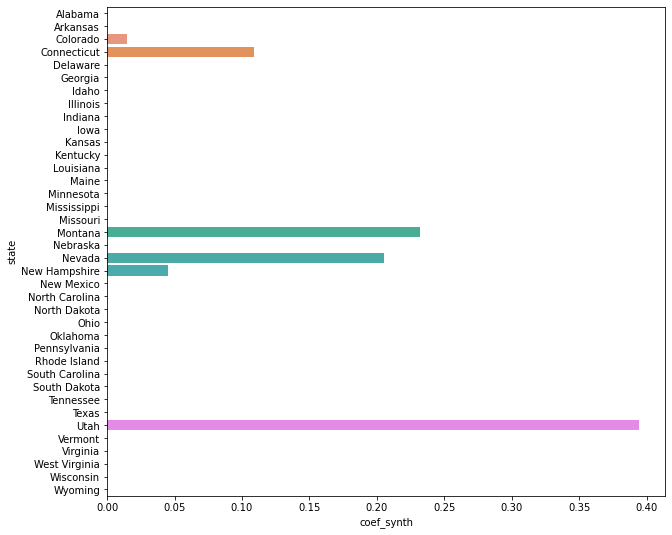

In [15]:
plt.figure(figsize=(10, 9))
sns.barplot(data=df_states, x='coef_synth', y='state');

In [16]:
df_states[df_states['coef_synth']>0]

,state,coef_synth
2,Colorado,1.482036e-02
3,Connecticut,1.091034e-01
4,Delaware,1.468075e-13
6,Idaho,5.921995e-15
7,Illinois,1.223955e-13
9,Iowa,3.911356e-14
10,Kansas,6.235967e-14
13,Maine,3.403268e-14
14,Minnesota,4.664632e-14
17,Montana,2.318438e-01


In [17]:
def plot_difference(df, city, year, vline=True, hline=True, **kwargs):
    sns.lineplot(x=df['year'], y=df[city] - df[f'Synthetic {city}'], **kwargs)
    if vline: 
        plt.axvline(x=year, ls=":", color='C2', label='Intervention year', lw=3, zorder=100)
        plt.legend()
    if hline: sns.lineplot(x=df['year'], y=0, lw=3, color='k', zorder=1)
    plt.title("Difference between observed and synthetic states");

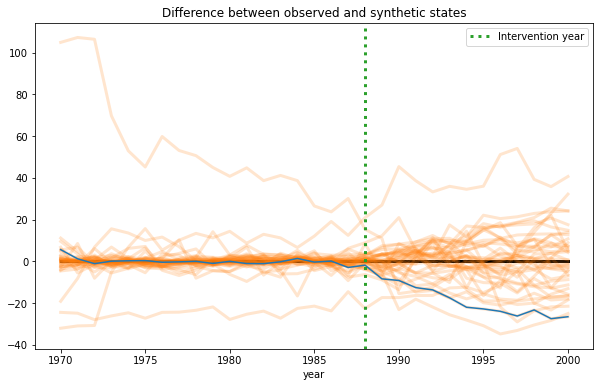

In [18]:
# fig, ax = plt.subplots()
plt.figure(figsize=(10,6))
for state in states:
    predict_synthetic_data(df, SyntheticControl(), state, treatment_year)
    plot_difference(df, state, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)
plot_difference(df, treated_state, treatment_year)

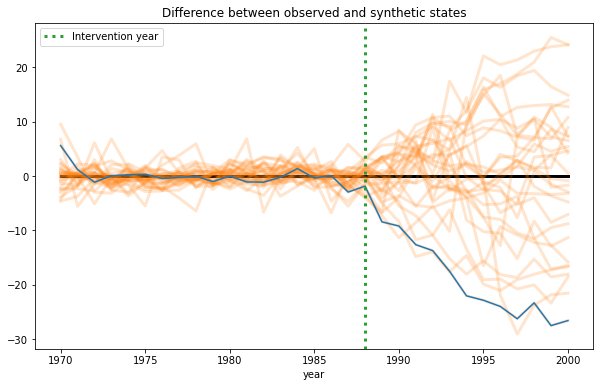

In [19]:
mse_treated = predict_synthetic_data(df, SyntheticControl(), treated_state, treatment_year).mse

# Other mse
plt.figure(figsize=(10,6))
for state in states:
    mse = predict_synthetic_data(df, SyntheticControl(), state, treatment_year).mse
    if mse < 2 * mse_treated:
        plot_difference(df, state, treatment_year, vline=False, alpha=0.2, color='C1', lw=3)
plot_difference(df, treated_state, treatment_year)


In [21]:
lambdas = {}
for state in states:
    mse_pre = predict_synthetic_data(df, SyntheticControl(), state, treatment_year).mse
    mse_tot = np.mean((df[f'Synthetic {state}'] - df[state])**2)
    lambdas[state] = (mse_tot - mse_pre) / mse_pre
    
print(f"p-value: {np.mean(np.fromiter(lambdas.values(), dtype='float') > lambdas[treated_state]):.4}")

p-value: 0.02564
